# 05: Using Surge's Filters

Surge has a rich set of filters with feedback and many types and subtypes. These are available for you
to configure using the parameter approach we've outlined in prior worksheets. Here we will demonstrate 
and test some of the filters, and see how they respond in various conditions.

Begin with our standard prologue.


In [1]:
import sys
sys.path.append( "../../surge/cmake-build-debug-xc" )

import os
import surgepy
import surgepy.constants as srco

import numpy as np
import math

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

surgepy.getVersion()

'1.8.more-python.185c1075'

One great way to understand a filter is to see the frequency response at various cutoffs and resonances.
There are a lot of ways to do this, including sending noise into the filter and taking an FFT of the output, 
but this notebook, both for debugging and pedagogical purposes, is going to take a more mechanical approach.

We know the surge sin oscillator at default configuration sends a simple sin wave out, a pure frequency,
and we know the serial filter configuration applies the filters. So what we can do is write a small function
which plays a sin wave for 0.1 seconds at every note from note 20-100 or so and sees the RMS of the
output. We can compare this with doing the same with no filter activated and get a response curve. 

So lets start by writing that function, given a filter type, subtype, cutoff, and resonance, and an
instance of a surge synthesizer, configure the surge for the filter as desired, and then play
the notes and grab the output. In surge, the cutoff is specified in notes with cutoff 0 being A440,
and the resonance is a value 0-1 for all filters.

For sin waves, there's the useful identity that two sin wave signals with the same frequency differing by phase
phi obey the relationship `cos(phi) = integral(a * b) / sqrt( integral a^2 * integral b^2)` which we use
here to estimate phase also.

In [2]:
def playNotesAcrossFilter( ftype, fsubtype, cutoff, resonance ):
    # Lets create two surges, one for our reference sin and one for our filtered
    # approach
    surgeNoF = surgepy.createSurge(44100)
    surgeF   = surgepy.createSurge(44100)
    
    # We go the route of loading the Init Sine patch here although we could of
    # course model it ourselves with params
    fd = surgeNoF.getFactoryDataPath()
    isin = os.path.join(fd, "patches_factory/Templates/Init Sine.fxp")
    surgeNoF.loadPatch(isin)
    surgeF.loadPatch(isin)
    
    patch = surgeF.getPatch()
    filtu = patch["scene"][0]["filterunit"][0]

    surgeF.setParamVal( filtu["type"], ftype )
    surgeF.setParamVal( filtu["subtype"], fsubtype )
    surgeF.setParamVal( filtu["cutoff"], cutoff )
    surgeF.setParamVal( filtu["resonance"], resonance )

    blockLen = int(surgeF.getSampleRate() / surgeF.getBlockSize() / 10)

    nNotes = 70
    notes = np.zeros(nNotes)
    rmses = np.zeros(nNotes)
    rmsesN = np.zeros(nNotes)
    phases = np.zeros(nNotes)
    
    for n0 in range(nNotes):
        note = n0 + 25
        notes[n0] = note
        mF = surgeF.createMultiBlock( blockLen )
        surgeF.playNote(0, note, 127, 0 )
        surgeF.processMultiBlock(mF)
        rms = np.sqrt( np.mean( np.square( mF[0] + mF[1])))
        rmses[n0] = rms
    
        
        mNoF = surgeF.createMultiBlock( blockLen )
        surgeNoF.playNote(0, note, 127, 0 )
        surgeNoF.processMultiBlock(mNoF)
        rmsN = np.sqrt( np.mean( np.square( mNoF[0] + mNoF[1])))
        rmsesN[n0] = rmsN
        
        cosphi = np.mean((mF[0] + mF[1]) * (mNoF[0] + mNoF[1])) / (rms * rmsN )
        phases[n0] = math.acos(cosphi)
        
        # Let it quiesce
        surgeF.releaseNote( 0, note, 0 )
        surgeNoF.releaseNote( 0, note, 0 )
        for i in range(50):
            surgeF.process()
            surgeNoF.process()
    
    res= {"notes" : notes, "rmsF" : rmses, "rmsNoF" : rmsesN, "rms" : rmses / rmsesN,
          "phase" : phases,
          "display" : {
              "type" : surgeF.getParamDisplay( filtu["type"]),
              "subtype" : surgeF.getParamDisplay( filtu["subtype"]),
              "cutoff" : surgeF.getParamDisplay( filtu["cutoff"]),
              "resonance" : surgeF.getParamDisplay( filtu["resonance"])
          }
         }
    
    return res


And now that function is defined, lets sweep across the OBXD 4 pole filter at a variety of resonances and make a plot

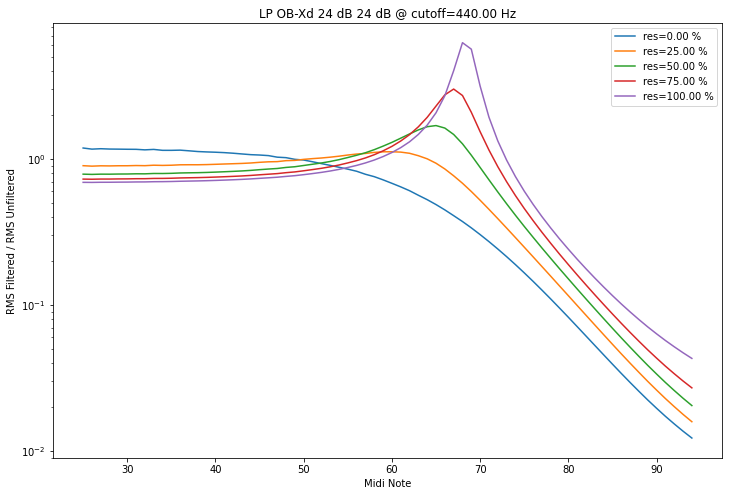

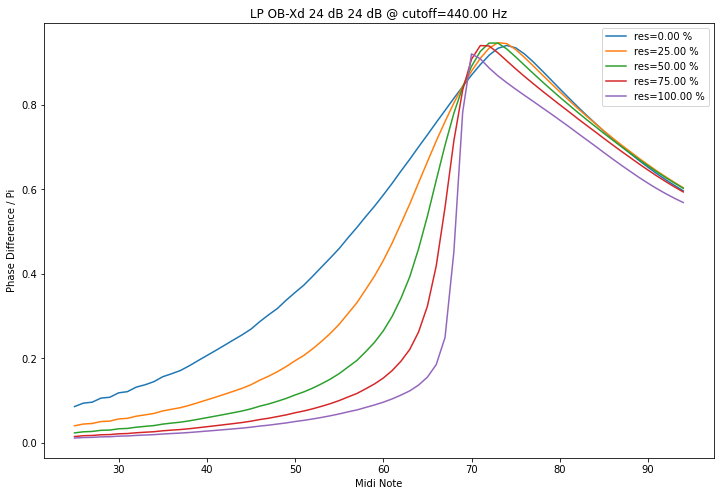

In [3]:
flp24s = []
for res in range(5):
    flp24s.append( playNotesAcrossFilter( srco.fut_obxd_4pole, 3, 0, res * 0.25 ) )
    
for flp24 in flp24s:
    plt.semilogy( flp24["notes"], flp24["rms"], label="res=" + flp24["display"]["resonance"])
    
plt.title( flp24["display"]["type"] + " " + flp24["display"]["subtype"] + " @ cutoff=" + flp24["display"]["cutoff"])
plt.xlabel( "Midi Note" );
plt.ylabel( "RMS Filtered / RMS Unfiltered")
plt.legend()

plt.show()


for flp24 in flp24s:
    plt.plot( flp24["notes"], flp24["phase"] / math.pi, label="res=" + flp24["display"]["resonance"])
    
plt.title( flp24["display"]["type"] + " " + flp24["display"]["subtype"] + " @ cutoff=" + flp24["display"]["cutoff"])
plt.xlabel( "Midi Note" );
plt.ylabel( "Phase Difference / Pi")
plt.legend()

plt.show()

And similarly lets compare the subtypes at resonance root 2 / 2.

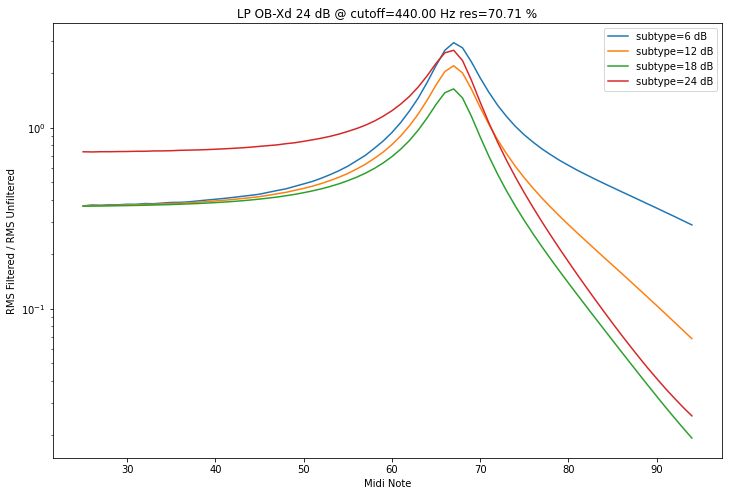

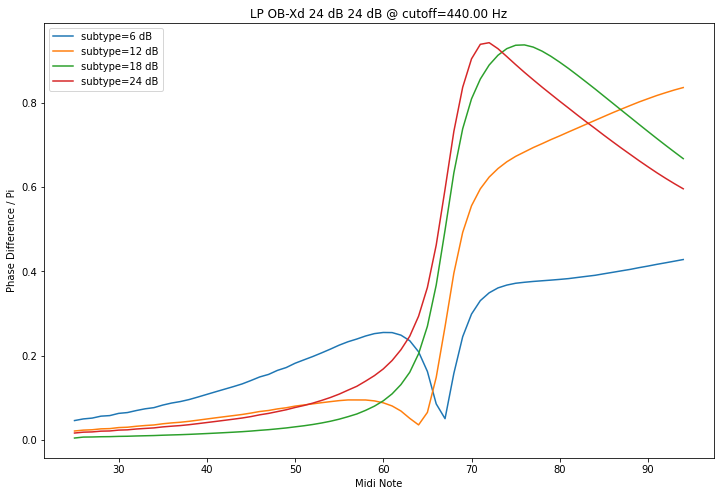

In [4]:

flp24s = []
for sub in range(4):
    flp24s.append( playNotesAcrossFilter( srco.fut_obxd_4pole, sub, 0, math.sqrt(2.0) * 0.5 ) )
    
for flp24 in flp24s:
    plt.semilogy( flp24["notes"], flp24["rms"], label="subtype=" + flp24["display"]["subtype"])
    
plt.title( flp24["display"]["type"] + " @ cutoff=" + flp24["display"]["cutoff"] + " res=" + flp24["display"]["resonance"])
plt.xlabel( "Midi Note" );
plt.ylabel( "RMS Filtered / RMS Unfiltered")
plt.legend()

plt.show()


for flp24 in flp24s:
    plt.plot( flp24["notes"], flp24["phase"] / math.pi, label="subtype=" + flp24["display"]["subtype"])
    
plt.title( flp24["display"]["type"] + " " + flp24["display"]["subtype"] + " @ cutoff=" + flp24["display"]["cutoff"])
plt.xlabel( "Midi Note" );
plt.ylabel( "Phase Difference / Pi")
plt.legend()

plt.show()